<a href="https://colab.research.google.com/github/ipodobin/big-crime/blob/terraform-init/Kopia_notatnika_crimePraca9Wsad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip3 install pyspark

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from collections import defaultdict
from google.colab import drive
drive.mount('/content/drive')
from statsmodels.tsa.holtwinters import ExponentialSmoothing


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import to_date, to_timestamp, date_format, year, month, concat_ws, dayofmonth, day, count, weekofyear, expr, col, asc

from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("Join CSV Files") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [13]:
#głowna baza
df1 = spark.read.csv('/content/drive/MyDrive/crime/Crimes_-_2001_to_Present_20240311.csv', header=True, inferSchema=True)
# dane statyczne
df2 = spark.read.csv('/content/drive/MyDrive/crime/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012_20240301.csv', header=True, inferSchema=True)
df3 = spark.read.csv('/content/drive/MyDrive/crime/Census_Data_-_Languages_spoken_in_Chicago__2008___2012_20240301.csv', header=True, inferSchema=True)
df4 = spark.read.csv('/content/drive/MyDrive/crime/Public_Health_Statistics_-_Selected_public_health_indicators_by_Chicago_community_area_-_Historical_20240301.csv', header=True, inferSchema=True)

In [14]:
#czyszczenie z nulli
years_to_drop = ['2001', '2002']
df1 = df1.filter(~df1['Year'].isin(years_to_drop)).dropna()
#joiny
df2 = df2.withColumnRenamed("Community Area Number", "Community Area")
joined_df = df1.join(df2, ["Community Area"]).drop(col("COMMUNITY AREA NAME"))
joined_df = joined_df.join(df3, ["Community Area"]).drop(col("Community Area Name"))
joined_df = joined_df.join(df4, ["Community Area"])
joined_df = joined_df.withColumn('Date', to_timestamp(joined_df['Date'], 'MM/dd/yyyy hh:mm:ss a'))
joined_df = joined_df.withColumn('Date_only', to_date(joined_df['Date']))
joined_df = joined_df.withColumn('Time_only', date_format(joined_df['Date'], 'HH:mm:ss'))


df = joined_df.orderBy('Date', ascending=True)
#archiwizacja całosci na s3

#output_path = "path/to/save/parquet_file"

#df.write.parquet(output_path)



In [20]:

class PredictionModel:
    def __init__(self, df):
        self.df = df

    def prepare_daily_data(self):
        daily_df = self.df.withColumn("Year", year("Date")) \
                          .withColumn("Month", month("Date")) \
                          .withColumn("Day", dayofmonth("Date"))
        daily_df = daily_df.withColumn("YearMonthDay", to_date(concat_ws("-", daily_df["Year"], daily_df["Month"], daily_df["Day"]), "yyyy-MM-dd"))
        daily_agg_df = daily_df.groupBy("Year", "Month", "Day", "YearMonthDay") \
                               .agg(count("*").cast("int").alias("Count")) \
                               .orderBy("YearMonthDay")
        pd_daily_agg_df = daily_agg_df.toPandas()
        pd_daily_agg_df.set_index('YearMonthDay', inplace=True)
        pd_daily_agg_df = pd_daily_agg_df.drop(pd_daily_agg_df.index[-7])
        pd_daily_agg_df = pd_daily_agg_df.drop(['Year', 'Month', 'Day'], axis=1)
        pd_daily_agg_df_reset = pd_daily_agg_df.reset_index()
        return pd_daily_agg_df_reset

    def prepare_weekly_data(self):
        week_df = self.df.withColumn("Year", year("Date")).withColumn("Week", weekofyear("Date"))
        week_df = week_df.withColumn("YearWeek", concat_ws("-", week_df["Year"], F.format_string("%02d", week_df["Week"])))
        week_df = week_df.withColumn("WeekStartDate", expr("date_sub(next_day(to_date(concat(Year, '-01-01')), 'MO'), 8 - Week * 7)"))
        week_df = week_df.groupBy("Year", "Week", "YearWeek", "WeekStartDate").agg(F.count("*").cast("int").alias("Count")).orderBy("Year", "Week")
        pd_week_df = week_df.toPandas()
        pd_week_df.set_index('WeekStartDate', inplace=True)
        pd_week_df = pd_week_df.drop(pd_week_df.index[-1])
        pd_week_df = pd_week_df.drop(['Year', 'Week', 'YearWeek'], axis=1)
        pd_week_df = pd_week_df.reset_index()
        return pd_week_df

    def prepare_monthly_data(self):
        month_df = self.df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))
        month_df = month_df.withColumn("YearMonth", concat_ws("-", month_df["Year"], month_df["Month"]))
        month_df = month_df.withColumn("YearMonth", to_date(month_df["YearMonth"], "yyyy-MM"))
        month_df = month_df.groupBy("Year", "Month", "YearMonth").agg(count("*").cast("int").alias("Count")).orderBy("YearMonth")
        pd_month_df = month_df.toPandas()
        pd_month_df.set_index('YearMonth', inplace=True)
        pd_month_df = pd_month_df.drop(pd_month_df.index[-1])
        pd_month_df = pd_month_df.drop(['Year', 'Month'], axis=1)
        pd_month_df_reset = pd_month_df.reset_index()
        return pd_month_df_reset

    def fit_predict(self, data, seasonal_periods, N_test):
        train = data.iloc[:-N_test]
        test = data.iloc[-N_test:]

        train_idx = data.index <= train.index[-1]
        test_idx = data.index > train.index[-1]

        hw = ExponentialSmoothing(train['Count'], initialization_method='legacy-heuristic', trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        res_hw = hw.fit()

        data.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
        data.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
        return data, train, test, res_hw

    def plot(self, data):
        data[['Count', 'HoltWinters']].plot()

    def rmse(self, y, t):
        return np.sqrt(np.mean((y - t) ** 2))

    def mae(self, y, t):
        return np.mean(np.abs(y - t))

    def mape(self, y, t):
        return np.mean(np.abs((y - t) / y)) * 100

    def evaluate(self, train, test, res_hw, N_test):
        print("Train RMSE:", self.rmse(train['Count'], res_hw.fittedvalues))
        print("Test RMSE:", self.rmse(test['Count'], res_hw.forecast(N_test)))
        print("Train MAE:", self.mae(train['Count'], res_hw.fittedvalues))
        print("Test MAE:", self.mae(test['Count'], res_hw.forecast(N_test)))
        print("Train MAPE:", self.mape(train['Count'], res_hw.fittedvalues))
        print("Test MAPE:", self.mape(test['Count'], res_hw.forecast(N_test)))

Train RMSE: 87.32702774782507
Test RMSE: 108.03991432917397
Train MAE: 61.7896771761865
Test MAE: 86.4246326064257
Train MAPE: 7.203696551128082
Test MAPE: 24.521338788779467


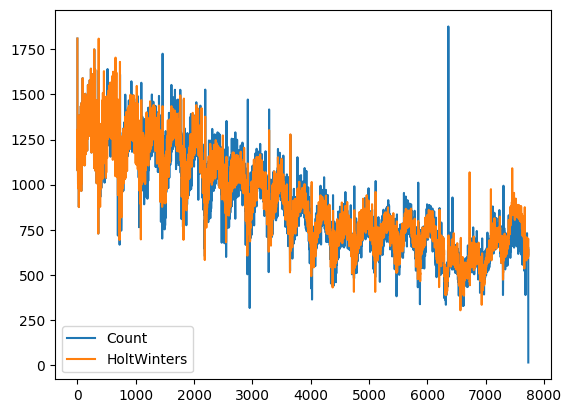

In [21]:
model = PredictionModel(df)

# Daily
pd_daily_agg_df_reset = model.prepare_daily_data()
daily_data, daily_train, daily_test, daily_res_hw = model.fit_predict(pd_daily_agg_df_reset, seasonal_periods=365, N_test=365)
model.plot(daily_data)
model.evaluate(daily_train, daily_test, daily_res_hw, N_test=365)


Train RMSE: 519.7008881685979
Test RMSE: 386.25413449261725
Train MAE: 324.04475367399846
Test MAE: 281.8174674270608
Train MAPE: 6.173699642631453
Test MAPE: 5.792927390309174


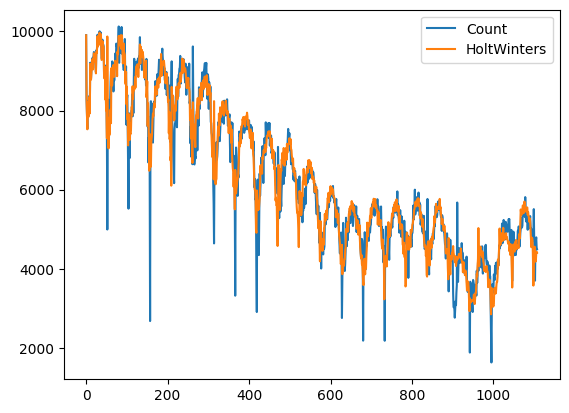

In [22]:
model = PredictionModel(df)


pd_week_df = model.prepare_weekly_data()
weekly_data, weekly_train, weekly_test, weekly_res_hw = model.fit_predict(pd_week_df, seasonal_periods=52, N_test=52)
model.plot(weekly_data)
model.evaluate(weekly_train, weekly_test, weekly_res_hw, N_test=52)

Train RMSE: 1111.214508127352
Test RMSE: 752.9695038461591
Train MAE: 807.9794757051395
Test MAE: 583.5029950656208
Train MAPE: 3.3322640446573453
Test MAPE: 2.8559820972477707


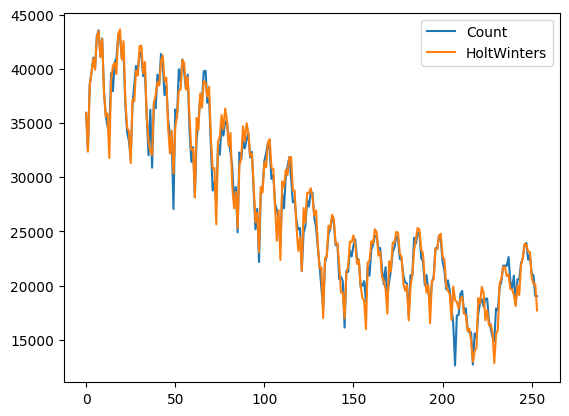

In [23]:
model = PredictionModel(df)


pd_month_df_reset = model.prepare_monthly_data()
monthly_data, monthly_train, monthly_test, monthly_res_hw = model.fit_predict(pd_month_df_reset, seasonal_periods=12, N_test=12)
model.plot(monthly_data)
model.evaluate(monthly_train, monthly_test, monthly_res_hw, N_test=12)